# 1. Intro

For an intro and more context about this project click <a href="https://github.com/4rn3/rl_school_project#readme">here<a/>

# 2. Algorithms & setup

In [1]:
import os, time, random
from collections import deque
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation, Monitor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

random.seed(1337)
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)

print(gym.__version__)
print(tf.__version__) #2.10 last version to support GPU on win
print(tf.config.list_physical_devices('GPU'))

0.19.0
2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
env = gym.make("SpaceInvaders-v4")
env = GrayScaleObservation(env,keep_dim=True)
env = ResizeObservation(env, (84,84)) #resize
env = FrameStack(env, 4) #gain extra info by combining multiple frames i.e is mario landing or jumping

In [3]:
print("Observation space: ", env.observation_space.shape)
print("# Actions: ", env.action_space.n)
print("Available actions: ", env.get_action_meanings())

Observation space:  (4, 84, 84, 1)
# Actions:  6
Available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


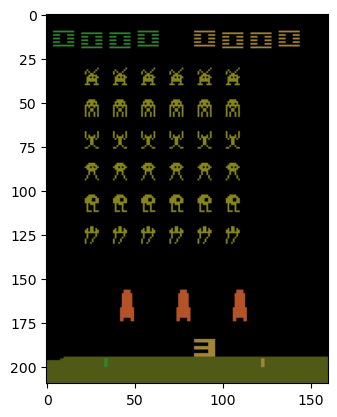

In [4]:
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)

In [5]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
   
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(200, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(200, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

# 2.1 DQN

In [12]:
#hyp
TRAIN_EPISODE = 10_000_000 #train till i'm back
TEST_EPISODE = 200
LR = 1e-3
MEM_LEN = 50000
BATCH_SIZE = 500
UPDATE_TARGET_TRESHOLD = 5
AGGREGATE_STATS = 15
MODEL_NAME = "DQN"
MIN_REPLAY_SIZE = 1000

#Bellman hyp
EPSILON = 1
MAX_EPSILON = 1
MIN_EPSILON = 0.01
DECAY = 0.03
BEL_LR = 0.7
DISCOUNT = 0.66

In [13]:
def agent(state_shape, action_shape):
    model = Sequential()
    #Feature generation
    model.add(Conv2D(32, (2, 2), strides=(4), input_shape=state_shape, activation="relu"))
    model.add(Conv2D(64, (1, 1), activation="relu"))
    model.add(Conv2D(64, (1, 1), activation="relu"))
    #Dim reduction
    model.add(Flatten())
    #FC classifier
    model.add(Dense(512, activation="relu"))
    model.add(Dense(action_shape, activation="linear"))
    
    model.compile(loss="mse", optimizer=Adam(learning_rate=LR), metrics=['accuracy'])    
    return model

In [14]:
model = agent(env.observation_space.shape, env.action_space.n) #init prediction model
target_model = agent(env.observation_space.shape, env.action_space.n) #init target model
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=MEM_LEN) #init memory

In [15]:
def batch_train(env, replay_memory, model, target_model, done):
    learning_rate = BEL_LR
    discount_factor = DISCOUNT
    
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    batch_size = BATCH_SIZE
    mini_batch = random.sample(replay_memory, batch_size)
    
    #Predicting the Q-values
    current_states = np.array([transition[0] for transition in mini_batch]) #add current_state from minibatch
    current_qs_list = model.predict(current_states, verbose=0)

    new_current_states = np.array([transition[3]for transition in mini_batch]) #add new_current_state from minibatch
    future_qs_list = target_model.predict(new_current_states, verbose=0)
  
    X, y = [], []

   #Updating Q-values
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward
            
        #Bellman
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        
        X.append(observation)
        y.append(current_qs)
    
    model.fit(np.array(X), np.array(y), batch_size=batch_size, verbose=0, shuffle=False)

In [ ]:
#Train loop
X, y, Total_rewards, time_tracking = [], [], [], []

steps_to_update_target_model = 0

for episode in trange(TRAIN_EPISODE):
    n_steps_episode = 0
    total_training_rewards = 0
    ep_rewards = []

    observation = env.reset()
    done = False
    
    while not done:
        #track time
        start = time.time()
        
        steps_to_update_target_model += 1
        random_number = np.random.rand()
        #Exploration
        if random_number <= EPSILON:
            action = env.action_space.sample()
        #Exploitation    
        else:
            predicted = model.predict(np.array(observation), verbose=0).flatten()
            action = np.argmax(predicted)

        new_observation, reward, done, info = env.step(action)
        total_training_rewards += reward
        ep_rewards.append(reward)
        
        replay_memory.append([observation, action, reward, new_observation, done])

        #Update prediction model
        if steps_to_update_target_model % 4 == 0 or done:
            batch_train(env, replay_memory, model, target_model, done)
        
        observation = new_observation
        
        n_steps_episode += 1
        
        if done:
            stop = time.time()
            time_tracking.append(stop-start)
            
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Total_rewards.append(total_training_rewards)

            #Update target model
            if steps_to_update_target_model >= UPDATE_TARGET_TRESHOLD:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    
    #Update epsilon 
    EPSILON = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY * episode)
    
    #Save model and metrics
    if episode % AGGREGATE_STATS == 0:
        avg_ep_reward = round(sum(ep_rewards)/len(ep_rewards),2)
        min_ep_reward = min(ep_rewards)
        max_ep_reward = max(ep_rewards)
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #not time per episod
        model.save(f'./models/{avg_ep_reward}_{str(episode)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/DQN.txt","a") as f:
            f.write(f"{avg_ep_reward},{min_ep_reward},{max_ep_reward},{avg_time},{EPSILON},{str(episode)}")
        
        time_tracking = []
env.close()

  0%|          | 0/30 [00:00<?, ?it/s]

0 Total training rewards: 105.0 after n steps = 673
Updating target model
Saving model
1 Total training rewards: 410.0 after n steps = 808
Updating target model
2 Total training rewards: 165.0 after n steps = 773
Updating target model
3 Total training rewards: 185.0 after n steps = 877
Updating target model


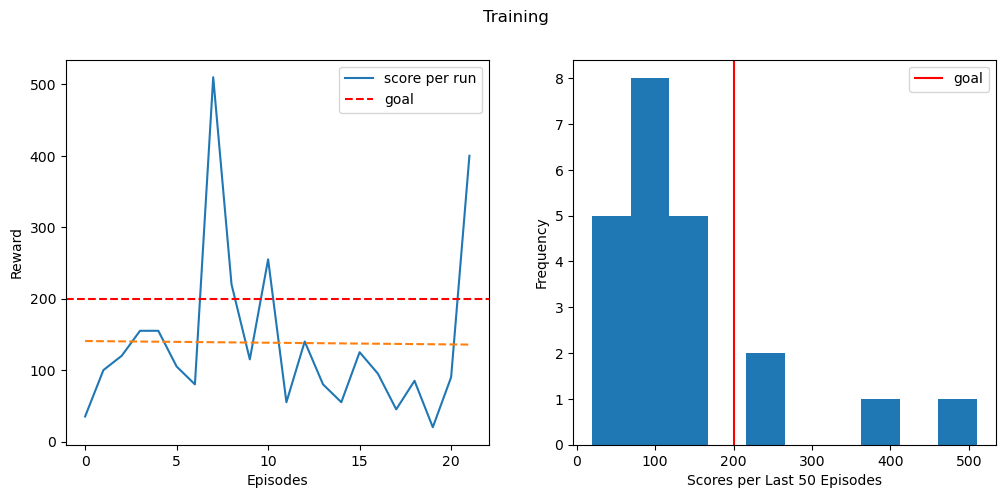

In [60]:
#Plot trainig
#TODO add extra plot for log file
plot_res(Total_rewards,'Training')

In [5]:
### Load the best model
best_model = sorted(os.listdir("./models"))[-1]
print("Loaded: ", best_model)
model = load_model(os.path.join("./models/",best_model), compile=False)

Loaded:  0.22_10_DQN.h5


In [ ]:
#Evaluate model
Total_reward = []
for episode in trange(TEST_EPISODE):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            predicted = model.predict(observation, verbose=0)
            action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1
        print('{} Reward = {}'.format(episode,total_training_rewards))
        Total_reward.append(total_training_rewards)
env.close()

In [ ]:
plot_res(Total_reward,'Test')

### 2.1.2 Compare model to random actions

In [8]:
#play 1 game of the best model
epochs, rewards = 0, 0
observation = env.reset()
done = False

#while not done: #use for while testing
for i in trange(1,5000):
    
    if done:
        break
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    rewards  += reward
    epochs += 1
    
env.close()
print(f"Reward: {rewards}") 

  0%|          | 0/4999 [00:00<?, ?it/s]

Reward: 135.0


In [7]:
#play 1 game with random actions
epochs, rewards = 0, 0


observation = env.reset()
done = False


#while not done: #use for while testing
for i in trange(1,5000) or done:
    
    if done:
        break
        
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    rewards  += reward
    epochs += 1
    
print(f"Reward: { rewards}")
env.close()

  0%|          | 0/4999 [00:00<?, ?it/s]

Reward: 110.0
